# **Stroke Prediction Using Machine Learning**

#### This project is an attempt to build a machine learning model to predict the chances of stroke to a user.
#### The model will consist of a front-end GUI for collecting data. Flask file to connect the model to backend model.
#### For the backend model we will be comparining 10 different ML algorithms for their accuracy. Select the best one and perform k-fold validation and hyper-parameter optimization on it.

### Contents
Here we will link every step that we took for selecting our backend model

# 0. Importing the Necessary Libraries

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import seaborn as sns; sns.set()
import graphviz 
import os
import preprocessing 
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from wordcloud import WordCloud

from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings("ignore")

---

# 1. Importing and Exploring Dataset

In [2]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk("dataset"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

dataset\healthcare-dataset-stroke-data.csv
dataset\healthcare-dataset-stroke-data.xlsx
dataset\~$healthcare-dataset-stroke-data.xlsx
dataset\.ipynb_checkpoints\healthcare-dataset-stroke-data-checkpoint.csv


In [3]:
dataset = pd.read_csv('dataset/healthcare-dataset-stroke-data.csv')
dataset.sample(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
171,2458,Female,78.0,0,0,Yes,Private,Rural,235.63,32.3,never smoked,1
1297,18051,Female,54.0,0,0,Yes,Govt_job,Rural,91.61,25.2,never smoked,0
1079,14996,Male,66.0,0,0,Yes,Self-employed,Rural,85.98,28.0,Unknown,0
4869,69427,Female,29.0,0,0,No,Private,Urban,101.28,22.7,never smoked,0
3055,44192,Female,11.0,0,0,No,children,Urban,130.15,17.2,Unknown,0
2550,36858,Female,40.0,0,0,Yes,Private,Rural,72.76,24.0,formerly smoked,0
1818,26015,Female,66.0,0,0,Yes,Self-employed,Urban,101.45,NaN,Unknown,1
1723,24669,Female,77.0,0,1,Yes,Private,Rural,231.56,36.9,never smoked,1
1071,14892,Female,46.0,1,0,Yes,Private,Rural,81.58,36.2,never smoked,0
4122,58635,Female,72.0,0,0,Yes,Self-employed,Urban,74.17,35.5,formerly smoked,0


### Dropping column 'id' as it can cause unwanted correlation.

In [4]:
dataset.drop("id", axis=1, inplace=True)

In [5]:
dataset.sample(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
4452,Female,41.0,0,0,Yes,Private,Urban,76.34,28.0,Unknown,0
1242,Male,55.0,1,0,Yes,Self-employed,Rural,82.81,44.3,never smoked,0
3204,Male,15.0,0,0,No,Private,Urban,77.55,24.8,Unknown,0
2758,Male,41.0,0,0,No,Self-employed,Rural,60.73,28.0,never smoked,0
736,Female,22.0,0,0,Yes,Private,Rural,73.94,24.8,Unknown,0


## Variable Description

* id: unique identifier
* gender: "Male", "Female" or "Other"
* age: age of the patient
* hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
* heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
* ever_married: "No" or "Yes"
* work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
* Residence_type: "Rural" or "Urban"
* avg_glucose_level: average glucose level in blood
* bmi: body mass index
* smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
* stroke: 1 if the patient had a stroke or 0 if not

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


#### We have null variables in 'bmi' column. We will handle them after.

<a id="4"></a> 
## Univariate Variable Analysis

* **Categorical Variables:** 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'

* **Numerical Variables:** 'id', 'hypertension', 'heart_disease', 'stroke'

<a id="5"></a> 
### Categorical Variables

In [7]:
def bar_plot(variable):
    # get feature
    var = dataset[variable]
    # count number of categorical variable(value/sample)
    varValue = var.value_counts()
    
    # visualize
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()
    print("{}:\n{}".format(variable,varValue))

In [8]:
categorical = (dataset.dtypes == "object")
categorical_list = list(categorical[categorical].index)

print("Categorical variables:")
print(categorical_list)

Categorical variables:
['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


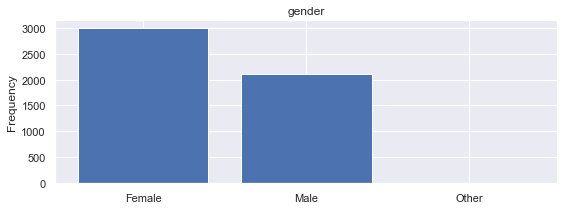

gender:
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


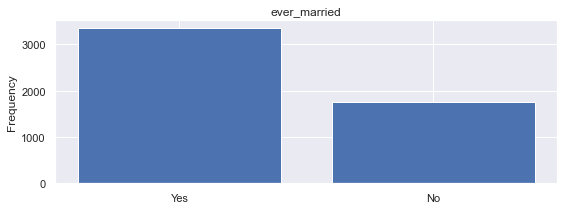

ever_married:
Yes    3353
No     1757
Name: ever_married, dtype: int64


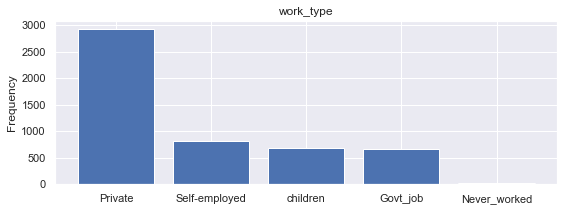

work_type:
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


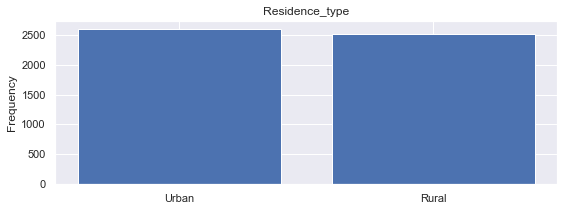

Residence_type:
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


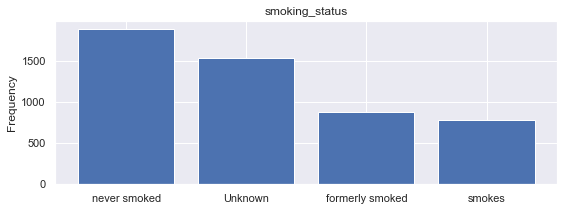

smoking_status:
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


In [9]:
sns.set_style('darkgrid')
categorical_variables = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for c in categorical_variables:
    bar_plot(c)

<AxesSubplot:xlabel='ever_married', ylabel='stroke'>

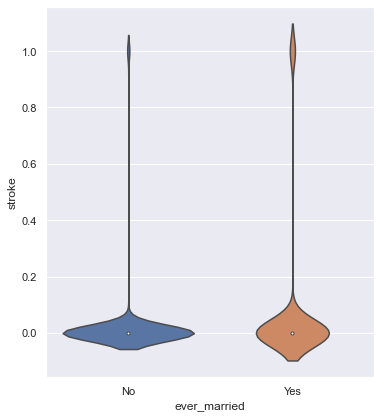

In [10]:
plt.figure(figsize=(20,15))
sns.set_theme(style="darkgrid")
plt.subplot(2,3,1)
sns.violinplot(x = 'ever_married', y = 'stroke', data = dataset)


<a id="6"></a> 
### Numerical Variables

In [11]:
numerical_int64 = (dataset.dtypes == "int64")
numerical_int64_list = list(numerical_int64[numerical_int64].index)

print("Categorical variables:")
print(numerical_int64_list)

Categorical variables:
['hypertension', 'heart_disease', 'stroke']


In [12]:
def plot_hist(variable):
    plt.figure(figsize = (9,3))
    plt.hist(dataset[variable], bins = 50)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(variable))
    plt.show()

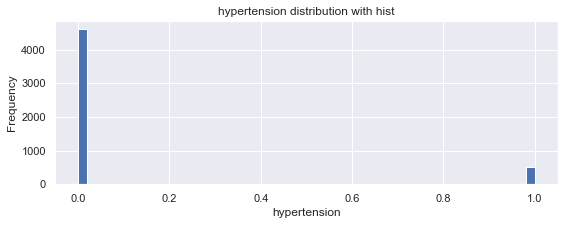

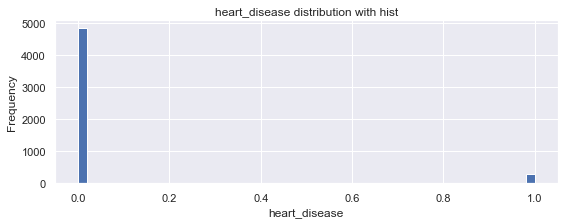

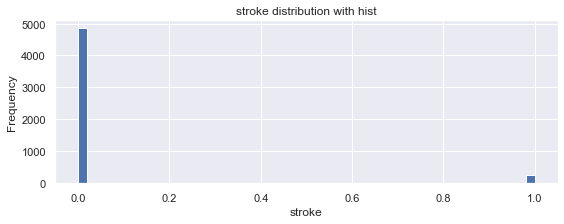

In [13]:
numerical_variables = ['hypertension', 'heart_disease', 'stroke']
for n in numerical_variables:
    plot_hist(n)

In [14]:
numerical_float64 = (dataset.dtypes == "float64")
numerical_float64_list = list(numerical_float64[numerical_float64].index)

print("Numerical variables:")
print(numerical_float64_list)

Numerical variables:
['age', 'avg_glucose_level', 'bmi']


In [15]:
def plot_hist(variable):
    plt.figure(figsize = (9,3))
    plt.hist(dataset[variable], bins = 50)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} Distribution with Histogram".format(variable))
    plt.show()

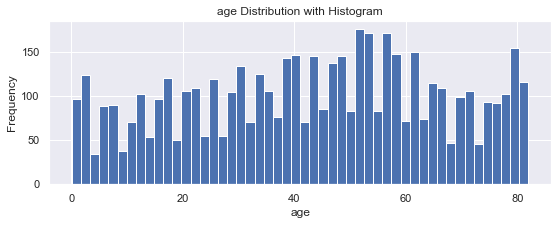

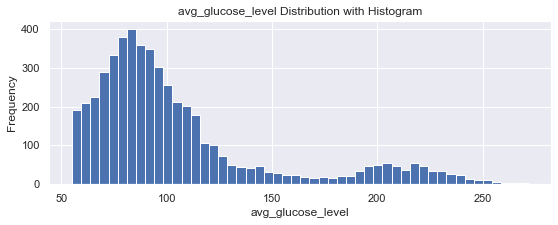

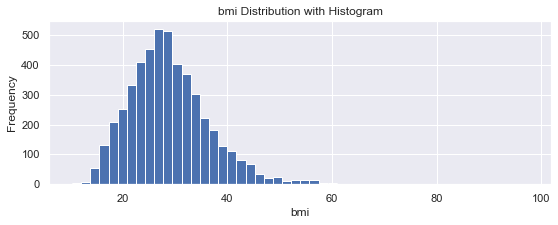

In [16]:
numerical_variables = ['age', 'avg_glucose_level', 'bmi']
for n in numerical_variables:
    plot_hist(n)

Text(0.5, 1.0, 'avg_glucose_level Interval and Counts')

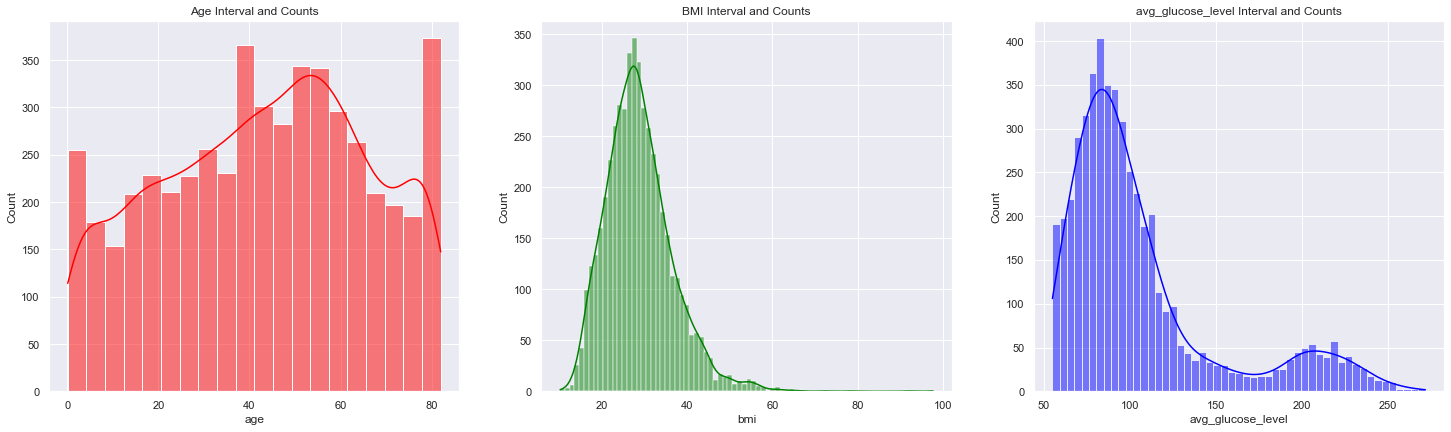

In [17]:
plt.figure(figsize=(25,15))

plt.subplot(2,3,1)
sns.histplot(dataset['age'], color = 'red', kde = True).set_title('Age Interval and Counts')

plt.subplot(2,3,2)
sns.histplot(dataset['bmi'], color = 'green', kde = True).set_title('BMI Interval and Counts')

plt.subplot(2,3,3)
sns.histplot(dataset['avg_glucose_level'], kde = True, color = 'blue').set_title('avg_glucose_level Interval and Counts')


Text(0.5, 1.0, 'Stroke Interval and Counts')

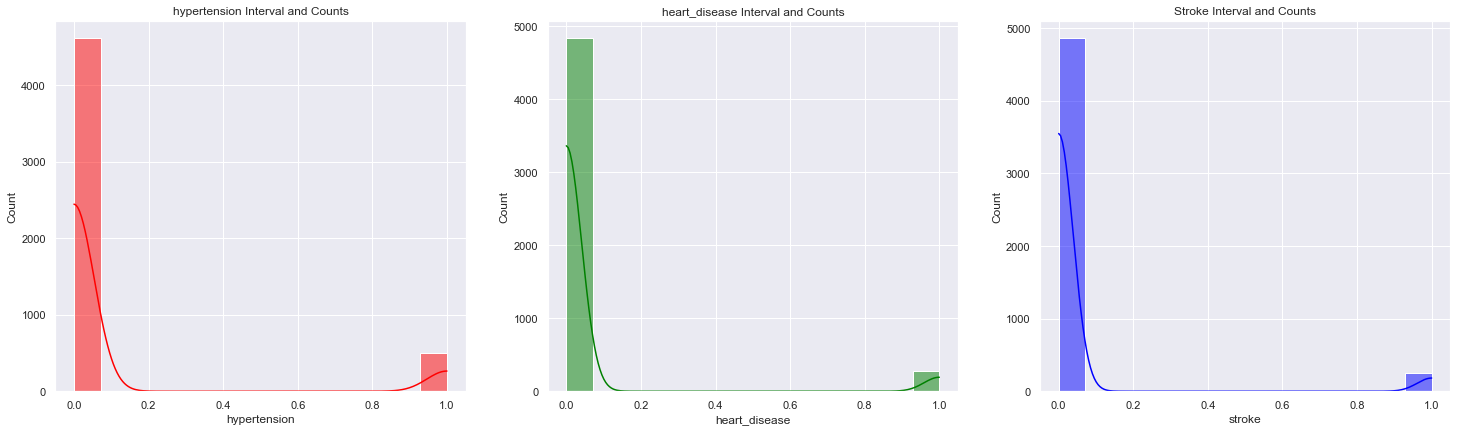

In [18]:
plt.figure(figsize=(25,15))

plt.subplot(2,3,1)
sns.histplot(dataset['hypertension'], color = 'red', kde = True).set_title('hypertension Interval and Counts')

plt.subplot(2,3,2)
sns.histplot(dataset['heart_disease'], color = 'green', kde = True).set_title('heart_disease Interval and Counts')

plt.subplot(2,3,3)
sns.histplot(dataset['stroke'], kde = True, color = 'blue').set_title('Stroke Interval and Counts')

<AxesSubplot:xlabel='stroke', ylabel='avg_glucose_level'>

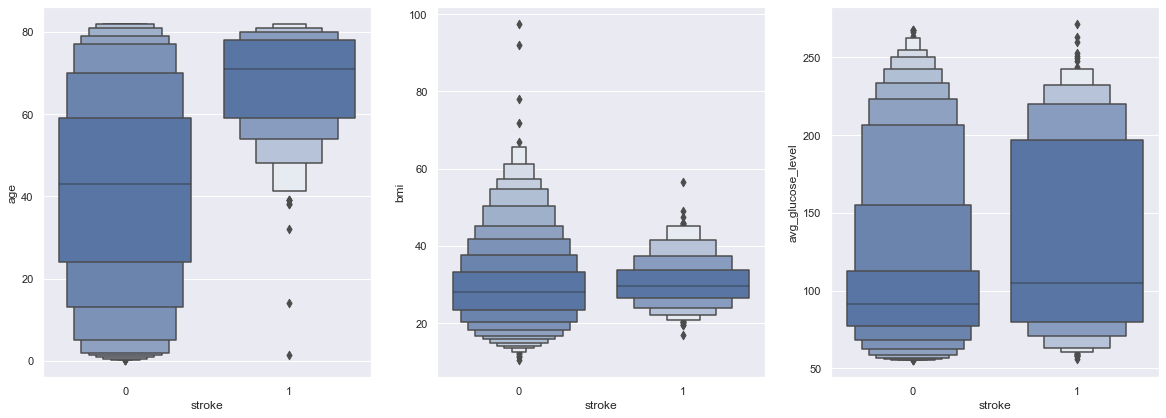

In [19]:
import seaborn as sns
sns.set_theme(style="darkgrid")


plt.figure(figsize=(20,15))

plt.subplot(2,3,1)
sns.boxenplot(x=dataset['stroke'], y=dataset['age'],
              color="b", 
              scale="linear", data=dataset)

plt.subplot(2,3,2)
sns.boxenplot(x=dataset['stroke'], y=dataset['bmi'],
              color="b", 
              scale="linear", data=dataset)

plt.subplot(2,3,3)
sns.boxenplot(x=dataset['stroke'], y=dataset['avg_glucose_level'],
              color="b", 
              scale="linear", data=dataset)

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

plt.figure(figsize=(20,15))

plt.subplot(2,2,1)
sns.swarmplot(x="stroke", y="age",hue="gender", data=dataset, palette="PRGn")

plt.subplot(2,2,2)
sns.swarmplot(x="stroke", y="age",hue="ever_married", data=dataset, palette="PRGn")

plt.subplot(2,2,3)
sns.swarmplot(x="stroke", y="age",hue="smoking_status", data=dataset, palette="PRGn")

plt.subplot(2,2,4)
sns.swarmplot(x="stroke", y="age",hue="work_type", data=dataset, palette="PRGn")

plt.show()

---

# 2. Basic Data Analysis

<a id="8"></a> 
## Gender - Stroke

#### Average stroke rate by gender. Male's stroke rate is higher.

In [ ]:
dataset[["gender","stroke"]].groupby(["gender"], as_index = False).mean().sort_values(by="stroke",ascending = False)

In [ ]:
df = dataset

labels = dataset['gender'].value_counts().index
pie1 = dataset['gender'].value_counts().values
# figure
fig = {
  "data": [
    {
      "values": pie1,
      "labels": labels,
      "domain": {"x": [0, .5]},
      "name": "",
      "hoverinfo":"label+percent+name+value",
      "hole": .2,
      "type": "pie"
    },],
  "layout": {
        "title":"Distribution of Genders",
        "annotations": [
            { "font": { "size": 25},
              "showarrow": True,
              "text": "Genders",
                "x": 1,
                "y": 1,
            },
        ]
    }
}
iplot(fig)
#plotly was not working in my system, so I made the pie using plt.

plt.figure(figsize = (8,8))
plt.pie(pie1, labels=labels, autopct='%1.1f%%')
plt.title("Distribution of Genders",color = 'black',fontsize = 15)

<a id="9"></a> 
## Ever Married - Stroke

#### stroke rate based on married or not

In [ ]:
dataset[["ever_married","stroke"]].groupby(["ever_married"], as_index = False).mean().sort_values(by="stroke",ascending = False)

In [ ]:
labels = dataset['ever_married'].value_counts().index
sizes = dataset['ever_married'].value_counts().values

plt.figure(figsize = (8,8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Distribution of Samples by 'ever_married'",color = 'black',fontsize = 15)

<a id="10"></a> 
## Work Type - Stroke

#### stroke rate based on work_type

In [ ]:
dataset[["work_type","stroke"]].groupby(["work_type"], as_index = False).mean().sort_values(by="stroke",ascending = False)

In [ ]:
dataset[["work_type","stroke"]].groupby(["work_type"], as_index = False).count().sort_values(by="stroke",ascending = False)

In [ ]:
df = dataset

labels = dataset['work_type'].value_counts().index
pie1 = dataset['work_type'].value_counts().values
# figure
fig = {
  "data": [
    {
      "values": pie1,
      "labels": labels,
      "domain": {"x": [0, .5]},
      "name": "",
      "hoverinfo":"label+percent+name+value",
      "hole": .2,
      "type": "pie",
    },],
  "layout": {
        "title":"Distribution of Work Type",
        "annotations": [
            { "font": { "size": 25},
              "showarrow": True,
              "text": "Work Type",
                "x": 1,
                "y": 1,
             
            },
        ]
    }
}
iplot(fig)

# plt.figure(figsize = (8,8))
# plt.pie(pie1, labels=labels, autopct='%1.1f%%')
# plt.title("Distribution of Work Types",color = 'black',fontsize = 15)

<a id="11"></a> 
## Residence_type - Stroke

#### stroke rate based on residence type.

In [ ]:
dataset[["Residence_type","stroke"]].groupby(["Residence_type"], as_index = False).mean().sort_values(by="stroke",ascending = False)

In [ ]:
counts = dataset['Residence_type'].value_counts()

plt.figure(figsize=(10,7))
sns.barplot(x=counts.index, y=counts.values, palette="Set3")

plt.ylabel('Count')
plt.xlabel('Residence_type', style = 'normal', size = 24)

plt.xticks(rotation = 45, size = 12)
plt.yticks(rotation = 45, size = 12)

plt.title('Distribution of Residence_type',color = 'black',fontsize=15)
plt.show()

<a id="12"></a> 
## smoking_status - Stroke

In [ ]:
dataset[["smoking_status","stroke"]].groupby(["smoking_status"], as_index = False).mean().sort_values(by="stroke",ascending = False)

In [ ]:
df = dataset

labels = dataset['smoking_status'].value_counts().index
pie1 = dataset['smoking_status'].value_counts().values
# figure
fig = {
  "data": [
    {
      "values": pie1,
      "labels": labels,
      "domain": {"x": [0, .5]},
      "name": "",
      "hoverinfo":"label+percent+name+value",
      "hole": .2,
      "type": "pie",
    },],
  "layout": {
        "title":"Distribution of Smoking Status",
        "annotations": [
            { "font": { "size": 25},
              "showarrow": True,
              "text": "Smoking Status",
                "x": 1,
                "y": 1,
             
            },
        ]
    }
}
iplot(fig)

# plt.figure(figsize = (8,8))
# plt.pie(pie1, labels=labels, autopct='%1.1f%%')
# plt.title("Distribution of Smoking Status",color = 'black',fontsize = 15)

---

<a id="13"></a> 
# 3. Pandas Profiling

#### Pandas profiling is a useful library that generates interactive reports about the data. With using this library, we can see types of data, distribution of data and various statistical information. This tool has many features for data preparing. Pandas Profiling includes graphics about specific feature and correlation maps too. You can see more details about this tool in the following url: https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/

In [ ]:
import pandas_profiling as pp
pp.ProfileReport(dataset)

---

<a id="14"></a> 
# 4. Correlation

#### Correlation explains how one or more variables are related to each other. These variables can be input data features which have been used to forecast our target variable.
https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/

In [ ]:
plt.figure(figsize=(12,8)) 
sns.heatmap(dataset.corr(), annot=True, cmap='Dark2_r', linewidths = 2)
plt.show()

In [ ]:
sns.pairplot(dataset, hue = 'stroke')

---

<a id="15"></a> 
# 5. Anomaly Detection

#### Anomaly is one that differs / deviates significantly from other observations in the same sample. An anomaly detection pattern produces two different results. The first is a categorical tag for whether the observation is abnormal or not; the second is a score or trust value. Score carries more information than the label. Because it also tells us how abnormal the observation is. The tag just tells you if it's abnormal. While labeling is more common in supervised methods, the score is more common in unsupervised and semisupervised methods.

In [ ]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

In [ ]:
dataset.loc[detect_outliers(dataset,['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 'stroke'])]

In [ ]:
# drop outliers
dataset = dataset.drop(detect_outliers(dataset,['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 'stroke']),axis = 0).reset_index(drop = True)

In [ ]:
dataset

---

<a id="16"></a> 
# 6. Missing Values

#### We have 201 null values in total. bmi includes all. (After Anomaly Detection, it decreases to 192)

<a id="17"></a> 
## bmi

In [ ]:
dataset[dataset['bmi'].isnull()]

***How can we handle null values?***

* We have selected the differences for BMI will be between gender.

In [ ]:
dataset.boxplot(column="bmi",by = "gender")
plt.show()

#### We get different BMI averages for women and men, although not very large. I will assign the total BMI mean as there are very few examples for the Others gender.

In [ ]:
print("Mean of BMI value for Females: ", np.mean(dataset[dataset['gender'] == 'Female']['bmi']))
print("Mean of BMI value for Males: ", np.mean(dataset[dataset['gender'] == 'Male']['bmi']))
print("Mean of BMI value for Others: ", np.mean(dataset['bmi']))

#### I filled null values with 0.

In [ ]:
dataset['bmi'] = dataset['bmi'].fillna(0)

In [ ]:
for i in range(0,5035):
    if(dataset['bmi'][i] == 0):
        if(dataset['gender'][i] == 'Male'):
            dataset['bmi'][i] = 28.594683544303823
        elif(dataset['gender'][i] == 'Female'):
            dataset['bmi'][i] = 29.035926055109936
        else:
            dataset['bmi'][i] = 28.854652338161664

In [ ]:
#testing null values in any attributes now
dataset[dataset['bmi'].isnull()]

---

<a id="18"></a> 
# 7. Encoding

#### First, we will handle Categorical Values.

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
print("Unique Values for Gender", dataset['gender'].unique())
print("Unique Values for ever_married", dataset['ever_married'].unique())
print("Unique Values for work_type", dataset['work_type'].unique())
print("Unique Values for Residence_type", dataset['Residence_type'].unique())
print("Unique Values for smoking_status", dataset['smoking_status'].unique())

<a id="19"></a> 
## Label Encoding

#### Label Encoding is an encoding technique for handling categorical variables. In this technique, each data is assigned a unique integer.

In [ ]:
ever_married_mapping = {'No': 0, 'Yes': 1}
dataset['ever_married'] = dataset['ever_married'].map(ever_married_mapping)

In [ ]:
Residence_type_mapping = {'Rural': 0, 'Urban': 1}
dataset['Residence_type'] = dataset['Residence_type'].map(Residence_type_mapping)

<a id="20"></a> 
## One-Hot Encoding

#### One Hot Encoding is the binary representation of categorical variables. This process requires categorical values to be mapped to integer values first. Next, each integer value is represented as a binary vector with all values zero except the integer index marked with 1.

#### One Hot Encoding makes the representation of categorical data more expressive and easy. Many machine learning algorithms cannot work directly with categorical data, so categories must be converted to numbers. This operation is required for input and output variables that are categorical.

#### In this part, we converted categorical datas to the binary values. This operation increases the accuracy.


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
onehotencoder = OneHotEncoder()

In [ ]:
dataset['gender'] = pd.Categorical(dataset['gender'])
datasetDummies_gender = pd.get_dummies(dataset['gender'], prefix = 'gender_encoded')
datasetDummies_gender

In [ ]:
dataset['work_type'] = pd.Categorical(dataset['work_type'])
datasetDummies_work_type = pd.get_dummies(dataset['work_type'], prefix = 'work_type_encoded')
datasetDummies_work_type

In [ ]:
dataset['smoking_status'] = pd.Categorical(dataset['smoking_status'])
datasetDummies_smoking_status = pd.get_dummies(dataset['smoking_status'], prefix = 'smoking_status_encoded')
datasetDummies_smoking_status

In [ ]:
dataset.drop("gender", axis=1, inplace=True)
dataset.drop("work_type", axis=1, inplace=True)
dataset.drop("smoking_status", axis=1, inplace=True)

In [ ]:
dataset = pd.concat([dataset, datasetDummies_gender], axis=1)
dataset = pd.concat([dataset, datasetDummies_work_type], axis=1)
dataset = pd.concat([dataset, datasetDummies_smoking_status], axis=1)
dataset

#### **Now, we don't have categorical variables. Dataset is ready for Machine Leraning algorithms.**

---

<a id="21"></a> 
# 8. Train - Test Split

In [ ]:
features = ['age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'gender_encoded_Female',
 'gender_encoded_Male',
 'gender_encoded_Other',
 'work_type_encoded_Govt_job',
 'work_type_encoded_Never_worked',
 'work_type_encoded_Private',
 'work_type_encoded_Self-employed',
 'work_type_encoded_children',
 'smoking_status_encoded_Unknown',
 'smoking_status_encoded_formerly smoked',
 'smoking_status_encoded_never smoked',
 'smoking_status_encoded_smokes']

label = ['stroke']

X = dataset[features]
y = dataset[label]

In [55]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.preprocessing import normalize

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve

from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3) 
# X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)

print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
# print(f'Total # of sample in validation dataset: {len(X_valid)}')
print(f'Total # of sample in test dataset: {len(X_test)}')

Total # of sample in whole dataset: 5035
Total # of sample in train dataset: 4028
Total # of sample in test dataset: 1007


#### Standardization is a method in which the mean value is 0 and the standard deviation is 1, and the distribution approaches the normal. The formula is as follows, we subtract the average value from the value we have, then divide it by the variance value.

In [57]:
sc=StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Saving the scaler object

In [58]:
import pickle
import os
scaler_path = os.path.join('models/scaler1.pkl')
with open(scaler_path,'wb') as scaler_file:
    pickle.dump(sc,scaler_file)

print("Saved scaler object")

Saved scaler object


---

<a id="22"></a> 
# 9. Training & Scores of Models

#### These are the ML algorithms that will apply to dataset. Results will contain train-validation-test scores, confusion matrix, statistical information and classification reports for each algorithm.

In [59]:
models = {
    'GaussianNB': GaussianNB(),
    'BernoulliNB': BernoulliNB(),
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'SupportVectorMachine': SVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'Stochastic Gradient Descent':  SGDClassifier(max_iter=5000, random_state=0),
    'Neural Nets': MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1),
}

modelNames = ["GaussianNB", 'BernoulliNB','LogisticRegression','RandomForestClassifier','SupportVectorMachine',
             'DecisionTreeClassifier', 'KNeighborsClassifier','GradientBoostingClassifier',
             'Stochastic Gradient Descent', 'Neural Nets']

trainScores = []
validationScores = []
testScores = []

for m in models:
  model = models[m]
  model.fit(X_train, y_train)
#   score = model.score(X_valid, y_valid)
  #print(f'{m} validation score => {score*100}') #not needed
    
  print(f'{m}') 
  train_score = model.score(X_train, y_train)
  print(f'Train score of trained model: {train_score*100}')
  trainScores.append(train_score*100)

#   validation_score = model.score(X_valid, y_valid)
#   print(f'Validation score of trained model: {validation_score*100}')
#   validationScores.append(validation_score*100)

  test_score = model.score(X_test, y_test)
  print(f'Test score of trained model: {test_score*100}')
  testScores.append(test_score*100)
  print(" ")
    
  y_predictions = model.predict(X_test)
  conf_matrix = confusion_matrix(y_predictions, y_test)

  print(f'Confussion Matrix: \n{conf_matrix}\n')

  predictions = model.predict(X_test)
  cm = confusion_matrix(predictions, y_test)

  tn = conf_matrix[0,0]
  fp = conf_matrix[0,1]
  tp = conf_matrix[1,1]
  fn = conf_matrix[1,0]
  accuracy  = (tp + tn) / (tp + fp + tn + fn)
  precision = tp / (tp + fp)
  recall    = tp / (tp + fn)
  f1score  = 2 * precision * recall / (precision + recall)
  specificity = tn / (tn + fp)
  print(f'Accuracy : {accuracy}')
#   print(f'Precision: {precision}')
#   print(f'Recall   : {recall}')
#   print(f'F1 score : {f1score}')
  print(f'Specificity : {specificity}')
  print("") 
  print(f'Classification Report: \n{classification_report(predictions, y_test)}\n')
  print("")

  for m in range (1):
    current = modelNames[m]
    modelNames.remove(modelNames[m])

  preds = model.predict(X_test) 
  confusion_matr = confusion_matrix(y_test, preds) #normalize = 'true' 
#   print(preds) # this list contains 831 values test values predictions by the model
#   print(confusion_matr) #confusion matrix for the test set by that particular model
  print("*********************************************************************************************")
  print("")
  print("")

GaussianNB
Train score of trained model: 17.9493545183714
Test score of trained model: 18.17279046673287
 
Confussion Matrix: 
[[145   1]
 [823  38]]

Accuracy : 0.1817279046673287
Specificity : 0.9931506849315068

Classification Report: 
              precision    recall  f1-score   support

           0       0.15      0.99      0.26       146
           1       0.97      0.04      0.08       861

    accuracy                           0.18      1007
   macro avg       0.56      0.52      0.17      1007
weighted avg       0.85      0.18      0.11      1007



*********************************************************************************************


BernoulliNB
Train score of trained model: 95.72989076464746
Test score of trained model: 95.8291956305859
 
Confussion Matrix: 
[[965  39]
 [  3   0]]

Accuracy : 0.958291956305859
Specificity : 0.9611553784860558

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.96      0.9

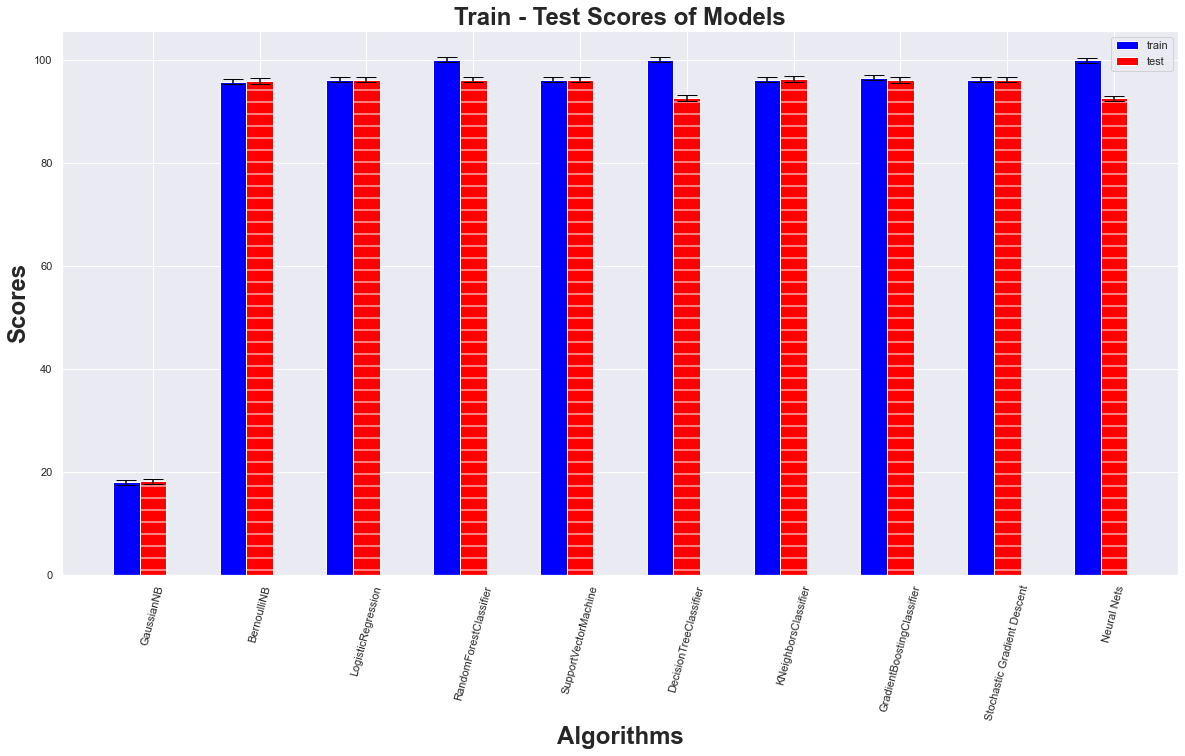

In [60]:
plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
# plt.title('Train - Validation - Test Scores of Models', fontweight='bold', size = 24)
plt.title('Train - Test Scores of Models', fontweight='bold', size = 24)

barWidth = 0.25
 
bars1 = trainScores
# bars2 = validationScores
bars3 = testScores
 
r1 = np.arange(len(bars1))
# r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, color='blue', width=barWidth, edgecolor='white', label='train', yerr=0.5,ecolor="black",capsize=10)
# plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='validation', yerr=0.5,ecolor="black",capsize=10, alpha = .50)
plt.bar(r3, bars3, color='red', width=barWidth, edgecolor='white', label='test', yerr=0.5,ecolor="black",capsize=10, hatch = '-')
 
modelNames = ["GaussianNB", 'BernoulliNB','LogisticRegression','RandomForestClassifier','SupportVectorMachine',
             'DecisionTreeClassifier', 'KNeighborsClassifier','GradientBoostingClassifier',
             'Stochastic Gradient Descent', 'Neural Nets']
    
plt.xlabel('Algorithms', fontweight='bold', size = 24)
plt.ylabel('Scores', fontweight='bold', size = 24)
plt.xticks([r + barWidth for r in range(len(bars1))], modelNames, rotation = 75)
 
plt.legend()
plt.show()

In [61]:
for i in range(10):
    print(f'Accuracy of {modelNames[i]} -----> {testScores[i]}')

Accuracy of GaussianNB -----> 18.17279046673287
Accuracy of BernoulliNB -----> 95.8291956305859
Accuracy of LogisticRegression -----> 96.1271102284012
Accuracy of RandomForestClassifier -----> 96.1271102284012
Accuracy of SupportVectorMachine -----> 96.1271102284012
Accuracy of DecisionTreeClassifier -----> 92.55213505461768
Accuracy of KNeighborsClassifier -----> 96.22641509433963
Accuracy of GradientBoostingClassifier -----> 96.02780536246276
Accuracy of Stochastic Gradient Descent -----> 96.1271102284012
Accuracy of Neural Nets -----> 92.45283018867924


#### The Highest is the *"Accuracy of KNeighborsClassifier -----> 96.22641509433963"*

---

<a id="23"></a> 
# 10. Evaluation of Models

In [ ]:
#### We evaluated these models according to their accuracies. Best algorithm is KNN with 96.03%. So, we will make k-Fold Cross Validation and Hyper-Parameter Optimization for KNN algorithm.

In [62]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

train_score = knn_model.score(X_train, y_train)
print(f'Train score of trained model: {train_score}')

# validation_score = knn_model.score(X_valid, y_valid)
# print(f'Validation score of trained model: {validation_score}')

test_score = knn_model.score(X_test, y_test)
print(f'Test score of trained model: {test_score}')

y_predictions = knn_model.predict(X_test)

conf_matrix = confusion_matrix(y_predictions, y_test)


print(f'Accuracy: {accuracy_score(y_predictions, y_test)*100}')
print()
print(f'Confussion matrix: \n{conf_matrix}\n')

Train score of trained model: 0.9612711022840119
Test score of trained model: 0.9622641509433962
Accuracy: 96.22641509433963

Confussion matrix: 
[[968  38]
 [  0   1]]



## Saving the best model prediction

In [63]:
import joblib
#saving the model**********************************************************************
model_path = os.path.join('models/knn.sav')
#C:\\Users\\msn21\\Desktop\\Major Project\\Stroke
#model_path=os.path.join('D:/Python37/Projects/Stroke Prediction/','models/dt.sav')
joblib.dump(knn_model,model_path)    
print("Saved knn_model") #***************************************************************

Saved knn_model


In [64]:
import plotly.graph_objects as go
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

mesh_size = .02
margin = 0.25

# Load and split data
X, y = make_moons(noise=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y.astype(str), test_size=0.2, random_state=3) 
# X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)

# Create a mesh grid on which we will run our model
x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)
xx, yy = np.meshgrid(xrange, yrange)

# Create classifier, run predictions on grid
clf = knn_model
clf.fit(X, y)
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)


# Plot the figure
fig = go.Figure(data=[
    go.Contour(
        x=xrange,
        y=yrange,
        z=Z,
        colorscale='purp'
    )
])
fig.show()

<a id="24"></a> 
## k-Fold Cross Validation

### Cross Validation will enable us to see whether we are facing an overfitting problem and also to see the quality of our model. Thus, it will enable us to test the performance of our model before encountering high error rates in the test data set that we have not seen yet. It is a method that is frequently used because it is easy to apply.

***cv = 10 means k = 10 for KNN.***

In [65]:
print(cross_val_score(knn_model, X = X_train, y = y_train, cv = 10))

[1.    0.875 1.    1.    0.75  1.    1.    0.875 0.875 1.   ]


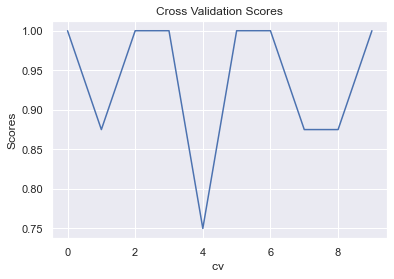

In [66]:
print(cross_val_score(knn_model, X = X_train, y = y_train, cv = 10))

In [67]:
accuracies = cross_val_score(estimator = knn_model, X = X_train, y = y_train, cv = 10)
print("Accuracy (mean):", accuracies.mean()*100, "%")
print("std: ", accuracies.std()*100)

Accuracy (mean): 93.75 %
std:  8.38525491562421


In statistics, mean absolute error (MAE) is a measure of errors between paired observations expressing the same phenomenon. Examples of Y versus X include comparisons of predicted versus observed, subsequent time versus initial time, and one technique of measurement versus an alternative technique of measurement. MAE is calculated as: 

Source: https://en.wikipedia.org/wiki/Mean_absolute_error

In [68]:
scores = cross_val_score(knn_model, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 10)
print ("MAE:", scores.mean())

MAE: -0.0625


<a id="25"></a> 
## Hyper-Parameter Optimization

#### Unlike parameters, hyperparameters are not learned during training the model. They are determined by the data scientist before the modeling phase. For example, KNN algorithm, which is one of the non-parametric classification algorithms, makes classification by looking at the nearest k neighbors to the desired value. Here, the k number (n_neighbors:) and the distance metric (metric:) to be used are the hyperparameters that should be specified by the data scientist before the modeling, which increases the performance of the model.

**Hyperparameter optimization** is the process of finding the most suitable hyperparameter combination according to the success metric specified for a machine learning algorithm.

#### Given that there are dozens of hyperparameters for a machine learning algorithm and dozens of values these hyperparameters can take, it's clear how difficult it will be to try all combinations one by one and pick the best combination. For this reason, different methods have been developed for hyperparameter optimization. GridSearcCV and RandomizedSearchCV are among these methods.

<a id="26"></a> 
### **GridSearchCV**

#### For the hyperparameters and their values that are desired to be tested in the model, a separate model is established with all combinations and the most successful hyperparameter set is determined according to the specified metric.

In [69]:
parameters = {'n_neighbors': [2,3,5,7,9,11,15,20],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
             'weights': ['uniform', 'distance'],
             'metric': ['manhattan', 'euclidean', 'minkowski', 'cosine', 'jaccard', 'hamming']
             }

gcv = GridSearchCV(knn_model, parameters, cv=5, verbose = 1, n_jobs = -1).fit(X_train, y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


In [70]:
print(f'GridSearchView Best Score: {gcv.best_score_*100}')
print(f'GridSearchView Best Estimator: {gcv.best_estimator_}')
print(f'GridSearchView Best Params: {gcv.best_params_}')

GridSearchView Best Score: 95.0
GridSearchView Best Estimator: KNeighborsClassifier(metric='euclidean', n_neighbors=3)
GridSearchView Best Params: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}


<a id="27"></a> 
### **RandomizedSearchCV**

#### A set of hyperparameters is randomly selected and tested by cross-validation and the model set up. These steps continue until the specified calculation time limit or the number of iterations is reached.

In [71]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
params = {'n_neighbors': [2,3,5,7,9,11,15,20],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
             'weights': ['uniform', 'distance'],
             'metric': ['manhattan', 'euclidean', 'minkowski', 'cosine', 'jaccard', 'hamming']
             }

randomizedcv = RandomizedSearchCV(knn_model, params, n_iter=200, cv=5, scoring='accuracy', n_jobs=-1, verbose=2).fit(X_train,y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [72]:
print(f'RandomizedSearchCV Best Score: {randomizedcv.best_score_*100}')
print(f'RandomizedSearchCV Best Estimator: {randomizedcv.best_estimator_}')
print(f'RandomizedSearchCV Best Params: {randomizedcv.best_params_}')

RandomizedSearchCV Best Score: 95.0
RandomizedSearchCV Best Estimator: KNeighborsClassifier(metric='euclidean', n_neighbors=3)
RandomizedSearchCV Best Params: {'weights': 'uniform', 'n_neighbors': 3, 'metric': 'euclidean', 'algorithm': 'auto'}


---

<a id="28"></a> 
## Best Features Selection

#### Feature Importance and Best Features

In [73]:
# I wrote this part again because X y changed above, in the k-nn visualization. 
features = ['age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'gender_encoded_Female',
 'gender_encoded_Male',
 'gender_encoded_Other',
 'work_type_encoded_Govt_job',
 'work_type_encoded_Never_worked',
 'work_type_encoded_Private',
 'work_type_encoded_Self-employed',
 'work_type_encoded_children',
 'smoking_status_encoded_Unknown',
 'smoking_status_encoded_formerly smoked',
 'smoking_status_encoded_never smoked',
 'smoking_status_encoded_smokes']

label = ['stroke']

X = dataset[features]
y = dataset[label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3) 
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)

print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in validation dataset: {len(X_valid)}')
print(f'Total # of sample in test dataset: {len(X_test)}')

sc=StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Total # of sample in whole dataset: 5035
Total # of sample in train dataset: 4028
Total # of sample in validation dataset: 503
Total # of sample in test dataset: 504


RandomForestClassifier
Old Shape: (5035, 19) New shape: (5035, 3)




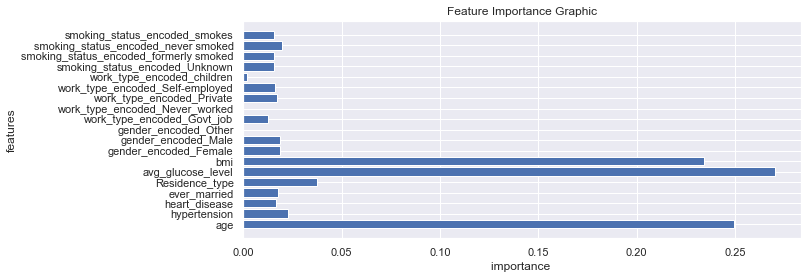

DecisionTreeClassifier
Old Shape: (5035, 19) New shape: (5035, 3)




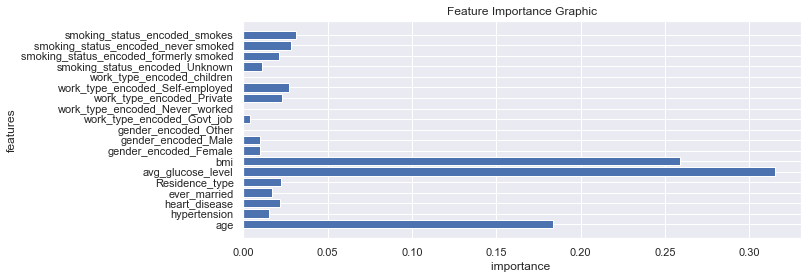

GradientBoostingClassifier
Old Shape: (5035, 19) New shape: (5035, 3)




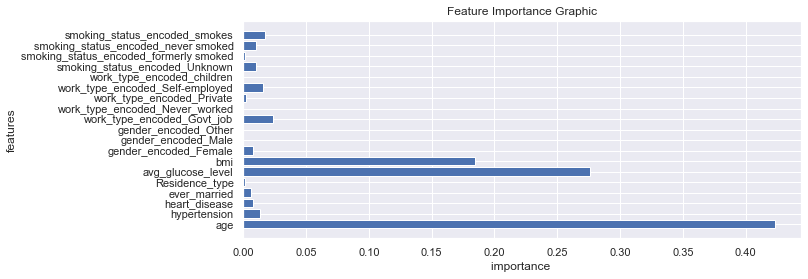

In [74]:
models = {
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
}

for m in models:
  model = models[m]
  model.fit(X_train, y_train)
  
  print(f'{m}') 
  best_features = SelectFromModel(model)
  best_features.fit(X, y)

  transformedX = best_features.transform(X)
  print(f"Old Shape: {X.shape} New shape: {transformedX.shape}")
  print("\n")

  imp_feature = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_})
  plt.figure(figsize=(10,4))
  plt.title("Feature Importance Graphic")
  plt.xlabel("importance ")
  plt.ylabel("features")
  plt.barh(imp_feature['Feature'],imp_feature['Importance'])
  plt.show()

In [75]:
models = {
    'BernoulliNB': BernoulliNB(),
    'LogisticRegression': LogisticRegression(),
    'Stochastic Gradient Descent':  SGDClassifier(max_iter=5000, random_state=0),
}

for m in models:
  model = models[m]
  model.fit(X_train, y_train)
  
  print(f'{m}') 
  best_features = SelectFromModel(model)
  best_features.fit(X, y)

  transformedX = best_features.transform(X)
  print(f"Old Shape: {X.shape} New shape: {transformedX.shape}")
  print("\n")

BernoulliNB
Old Shape: (5035, 19) New shape: (5035, 7)


LogisticRegression
Old Shape: (5035, 19) New shape: (5035, 10)


Stochastic Gradient Descent
Old Shape: (5035, 19) New shape: (5035, 7)




---

<a id="29"></a> 
# Conclusion

In this notebook, We examined Stroke Prediction Dataset. We analyzed the dataset then, tested various ML algorithms for the one with best accuracy. We saved it for using with GUI for providing prediction to the user for chances of stroke to him; based on the data provided by him/her using GUI 

* ***Thank you.***

In [ ]:
#6:37

- Accuracy of GaussianNB -----> 18.46031746031746
- Accuracy of BernoulliNB -----> 90.72222222222223
- Accuracy of LogisticRegression -----> 91.8555555555556
- Accuracy of RandomForestClassifier -----> 93.63492063492063
- Accuracy of SupportVectorMachine -----> 92.46031746031746
- Accuracy of DecisionTreeClassifier -----> 92.06349206349206
- Accuracy of KNeighborsClassifier -----> 96.03174603174604
- Accuracy of GradientBoostingClassifier -----> 94.63492063492063
- Accuracy of Stochastic Gradient Descent -----> 94.83333333333334
- Accuracy of Neural Nets -----> 93.05555555555556